In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
theme = ''
directory = 'C:/Users/gueux/source/repos/gencon/x64/Debug/'
if theme:
    theme = theme + '_'
pos_file = f'{directory}{theme}V1_pos.bin'
conMat_file = f'{directory}{theme}V1_conMat.bin'
delayMat_file = f'{directory}{theme}V1_delayMat.bin'
vec_file = f'{directory}{theme}V1_vec.bin'
blkPos_file = f'{directory}{theme}block_pos.bin'
nabaBlk_file = f'{directory}{theme}neighborBlock.bin'
stats_file = f'{directory}{theme}conStats.bin'
feature_file = f'{directory}{theme}V1_feature.bin'

In [4]:
with open(pos_file, 'r') as f:
    nblock = np.fromfile(f, 'u4', count=1)[0]
    blockSize = np.fromfile(f, 'u4', count=1)[0]
    dataDim = np.fromfile(f, 'u4', count=1)[0]
    pos = np.reshape(np.fromfile(f, 'f8'), (nblock,2,blockSize))
networkSize = nblock*blockSize

In [5]:
# read block center pos
with open(blkPos_file, 'rb') as f:
    blkPos = np.reshape(np.fromfile(f, 'f4', count = 2*nblock), (2,nblock))
# read block neighbor id
with open(nabaBlk_file,'rb') as f:
    nNabaBlk = np.fromfile(f, 'u4', count = nblock)
    nabaBlkId = np.empty(nblock,dtype=object)
    print(nNabaBlk)
    for i in range(nblock):
        nabaBlkId[i] = np.fromfile(f, 'u4', count = nNabaBlk[i])            
        print(nabaBlkId[i])

[4 6 8 8 6 5 7 8 8 7 5 5 8 7 6 7 8 5 5 7 6 6 6 6 7 5 3 5 5 5 5 3]
[1 2 3 4]
[0 2 3 5 6 7]
[0 8 1 3 4 5 6 7]
[ 0  8  1  9  2 10  4  7]
[ 0  8  9  2 10  3]
[ 1  2 11 12  6]
[ 1  2 11 12  5 13  7]
[ 8  1  2  3 12 13  6 14]
[16  9  2  3  4 14  7 15]
[16  8 17 10  3  4 15]
[16 17  9  3  4]
[18 19 12  5  6]
[18 19 11 20  5 13  6  7]
[19 20 12 21  6 14  7]
[ 8 21 13 22  7 15]
[16  8 24  9 22 14 23]
[ 8 24 17  9 25 10 23 15]
[16 24  9 25 10]
[26 19 11 27 12]
[18 26 11 27 20 12 13]
[19 27 12 28 21 13]
[20 28 13 29 22 14]
[28 21 29 14 23 15]
[16 24 29 22 30 15]
[16 17 25 30 23 15 31]
[16 24 17 30 31]
[18 19 27]
[18 26 19 20 28]
[27 20 21 29 22]
[28 21 22 30 23]
[24 25 29 23 31]
[24 25 30]


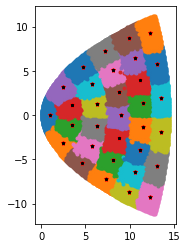

In [6]:
fig = plt.figure('pos')
ax = fig.add_subplot(111)
for i in range(nblock):
    plt.plot(pos[i,0,:], pos[i,1,:], '.')
    plt.plot(blkPos[0,i], blkPos[1,i], '*r', ms = 5)
for i in range(nblock):
    for j in range(nNabaBlk[i]):
        plt.plot(blkPos[0,nabaBlkId[i]], blkPos[1,nabaBlkId[i]], 'dk', ms = 1)
ax.set_aspect('equal')

In [7]:
with open(conMat_file, 'rb') as f:
    conMat = np.reshape(np.fromfile(f, 'f4', count = networkSize*blockSize),(nblock, blockSize, blockSize)) # pre, post
    
with open(delayMat_file, 'rb') as f:
    delayMat = np.reshape(np.fromfile(f, 'f4', count = networkSize*blockSize),(nblock, blockSize, blockSize)) # pre, post
    print(f'delays: {np.min(delayMat)}, {np.mean(delayMat)}, {np.max(delayMat)} ms')
    
with open(vec_file, 'rb') as f:
    nVec = np.fromfile(f, 'u4', count = networkSize)
    vecID = np.empty(networkSize,dtype=object)
    conVec = np.empty(networkSize,dtype=object)
    delayVec = np.empty(networkSize,dtype=object)
    for i in range(networkSize):
        if nVec[i] > 0:
            vecID[i] = np.fromfile(f, 'u4', count = nVec[i])
            conVec[i] = np.fromfile(f, 'f4', count = nVec[i])
            delayVec[i] = np.fromfile(f, 'f4', count = nVec[i])
        else:
            vecID[i] = np.array([])
            conVec[i] = np.array([])
            delayVec[i] = np.array([])
print(f'number of connections outside block: {np.min(nVec)}, {np.mean(nVec)}, {np.max(nVec)}')
with open(feature_file, 'rb') as f:
    nFeature = np.fromfile(f, 'u4', count = 1)[0]
    LR = np.fromfile(f,'f4', count = networkSize)

delays: 0.0, 1.0232422351837158, 2.187499523162842 ms
number of connections outside block: 0, 104.34320068359375, 340


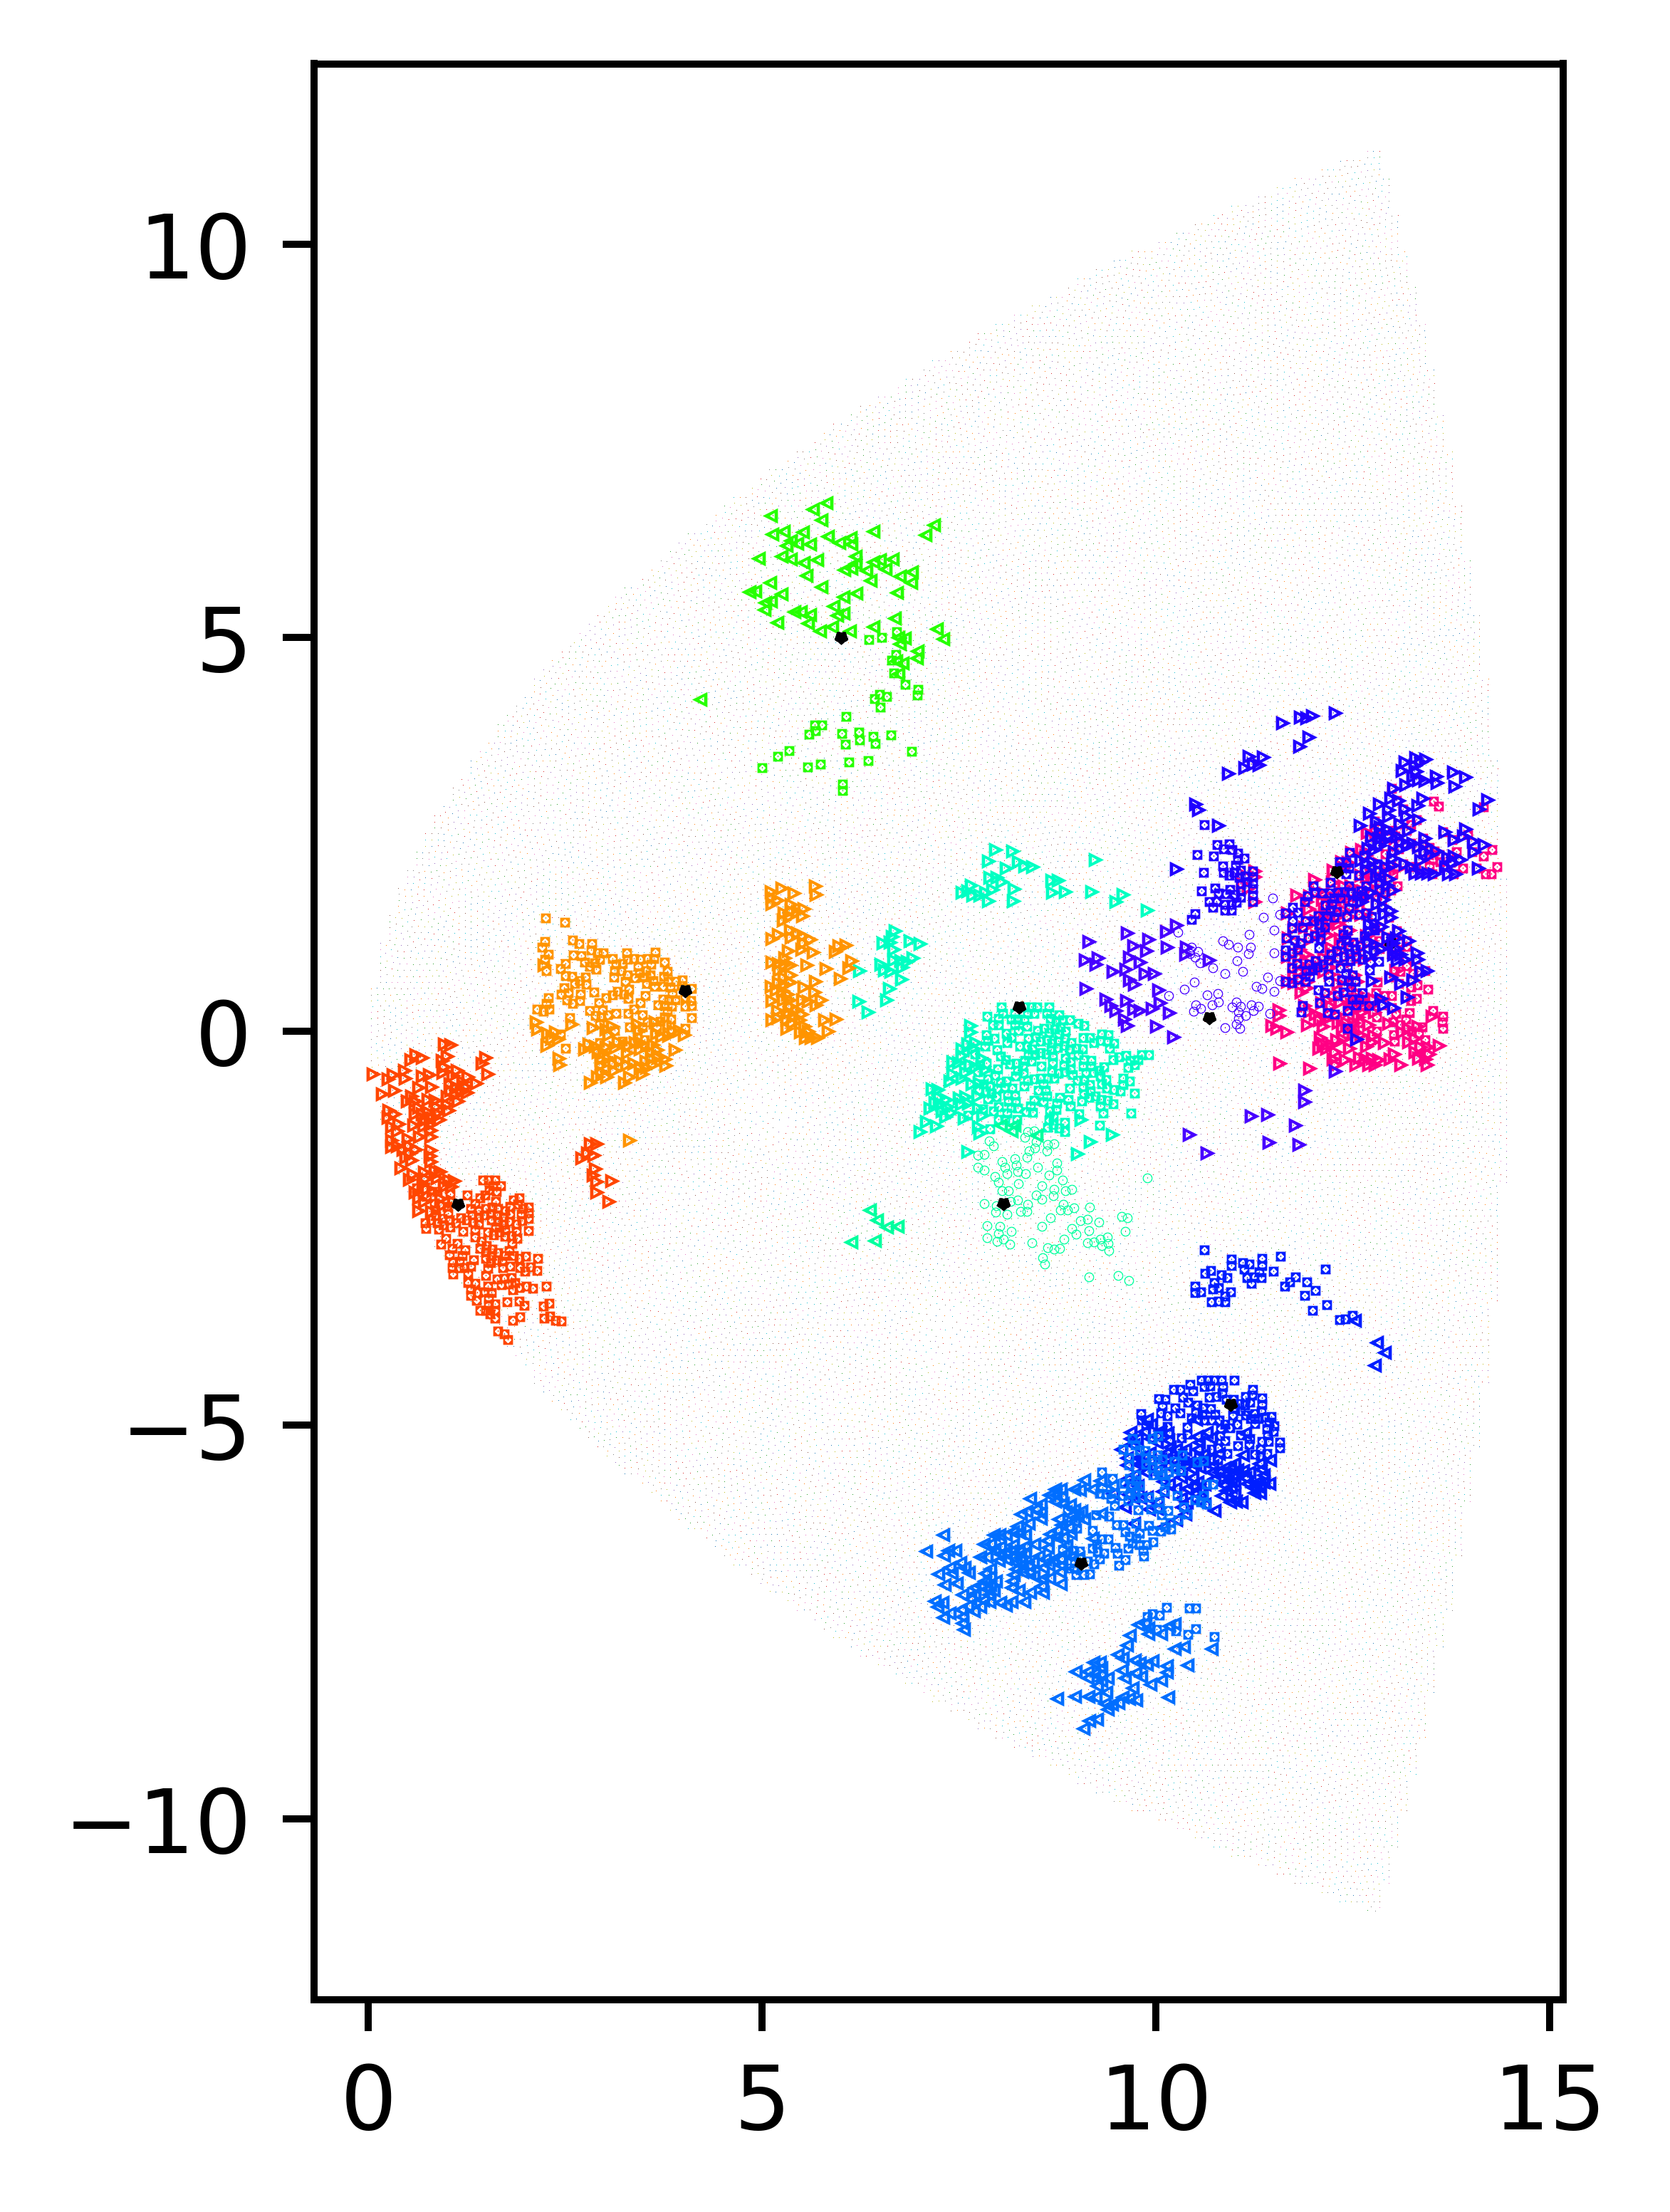

In [45]:
fig = plt.figure('con', dpi = 900)
ax = fig.add_subplot(111)
ax.plot(pos[:,0,:], pos[:,1,:], ',')
np.random.seed(9191254)
example = np.random.randint(0,networkSize,(10,))
#for i in example:

for i in example:
    color = mpl.colors.hsv_to_rgb([i/networkSize, 1, 1])
    bid = i//blockSize
    tid = i-blockSize*bid
    # post
    
    mat_pick = np.logical_and(conMat[bid,:,tid]>0, LR[bid*blockSize:(bid+1)*blockSize]<0)
    # pre within the block
    ax.plot(pos[bid,0,mat_pick], pos[bid,1,mat_pick], 'o', c=color, ms = 0.1)
    mat_pick = np.logical_and(conMat[bid,:,tid]>0, LR[bid*blockSize:(bid+1)*blockSize]>0)
    # pre within the block
    ax.plot(pos[bid,0,mat_pick], pos[bid,1,mat_pick], 's', c=color, ms = 0.1)
    if nVec[i] > 0:
        # pre outside the block
        L_pick = LR[nVec[i]] < 0
        vbid = vecID[i][L_pick]//blockSize
        vtid = vecID[i][L_pick] - blockSize*vbid
        ax.plot(pos[vbid,0,vtid], pos[vbid,1,vtid], '<', c=color, ms = 0.1)
        R_pick = LR[nVec[i]] > 0
        vbid = vecID[i][R_pick]//blockSize
        vtid = vecID[i][R_pick] - blockSize*vbid
        ax.plot(pos[vbid,0,vtid], pos[vbid,1,vtid], '>', c=color, ms = 0.1)
    ax.plot(pos[bid,0,tid], pos[bid,1,tid],'*k', ms = 1)
ax.set_aspect('equal')

In [19]:
with open(stats_file, 'rb') as f:
    nType = np.fromfile(f, 'u4', count=1)[0]
    networkSize = np.fromfile(f, 'u4', count=1)[0]
    connected = np.reshape(np.fromfile(f, 'u4', count=nType*networkSize), (nType, networkSize))
    avail = np.reshape(np.fromfile(f, 'u4', count=nType*networkSize), (nType, networkSize))
    strength = np.reshape(np.fromfile(f, 'f4', count=nType*networkSize), (nType, networkSize))

In [20]:
print(np.sum(avail,axis=-1))
print(np.sum(connected,axis=-1))

[109106695  36377171]
[3303039 7104788]


(array([  10.,   16.,   28.,   34.,   37.,   50.,   52.,   61.,   71.,
          70.,   91.,   87.,  122.,  161.,  213.,  304.,  490.,  748.,
         726.,  713.,  710.,  706.,  729.,  750.,  733.,  764.,  795.,
         825.,  827.,  804.,  853.,  799.,  735.,  650.,  662.,  431.,
         515.,  604.,  719.,  851., 1003., 1187., 1372., 1514., 1647.,
        1764., 1824., 1742., 1442.,  727.]),
 array([1344.  , 1433.32, 1522.64, 1611.96, 1701.28, 1790.6 , 1879.92,
        1969.24, 2058.56, 2147.88, 2237.2 , 2326.52, 2415.84, 2505.16,
        2594.48, 2683.8 , 2773.12, 2862.44, 2951.76, 3041.08, 3130.4 ,
        3219.72, 3309.04, 3398.36, 3487.68, 3577.  , 3666.32, 3755.64,
        3844.96, 3934.28, 4023.6 , 4112.92, 4202.24, 4291.56, 4380.88,
        4470.2 , 4559.52, 4648.84, 4738.16, 4827.48, 4916.8 , 5006.12,
        5095.44, 5184.76, 5274.08, 5363.4 , 5452.72, 5542.04, 5631.36,
        5720.68, 5810.  ]),
 <a list of 50 Patch objects>)

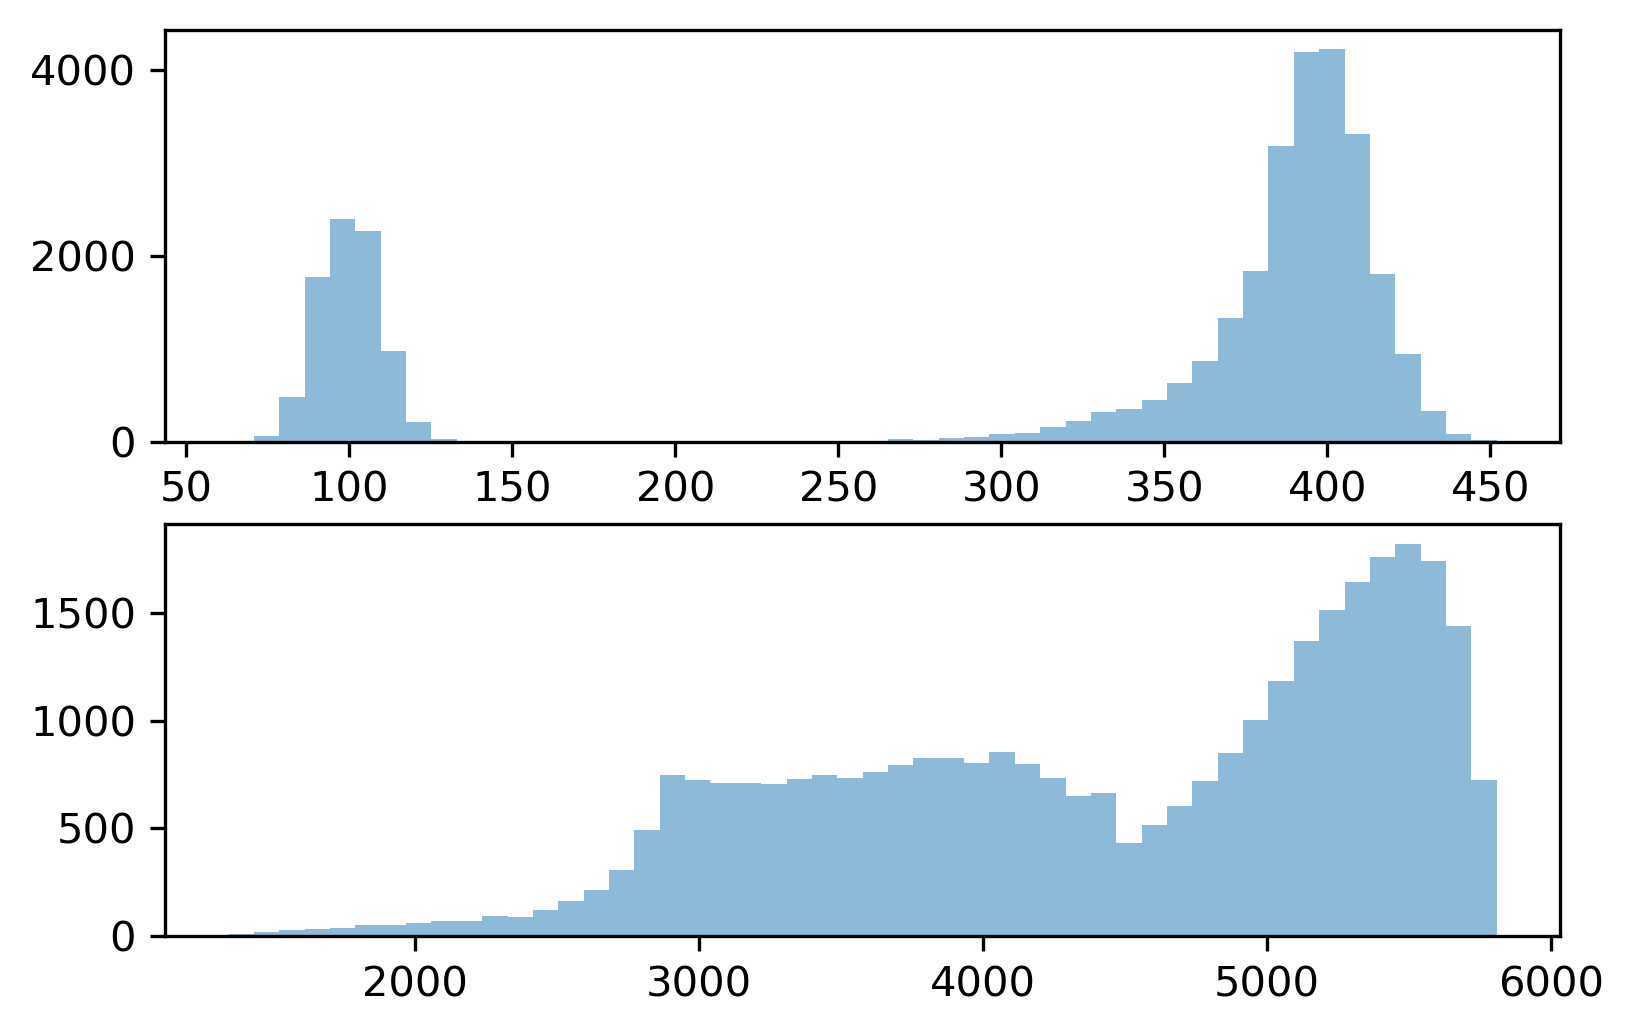

In [21]:
fig = plt.figure('stats', dpi = 300)
ax = fig.add_subplot(211)
ax.hist(np.sum(connected.T,axis=-1), bins = 50, alpha = 0.5)
ax = fig.add_subplot(212)
ax.hist(np.sum(avail.T,axis=-1), bins = 50, alpha = 0.5)
#ax.hist(strength.T, bins = 10)

0 0.04617020123820566 0.023825093739380573
1 0.25484268407832694 0.10189389478810659


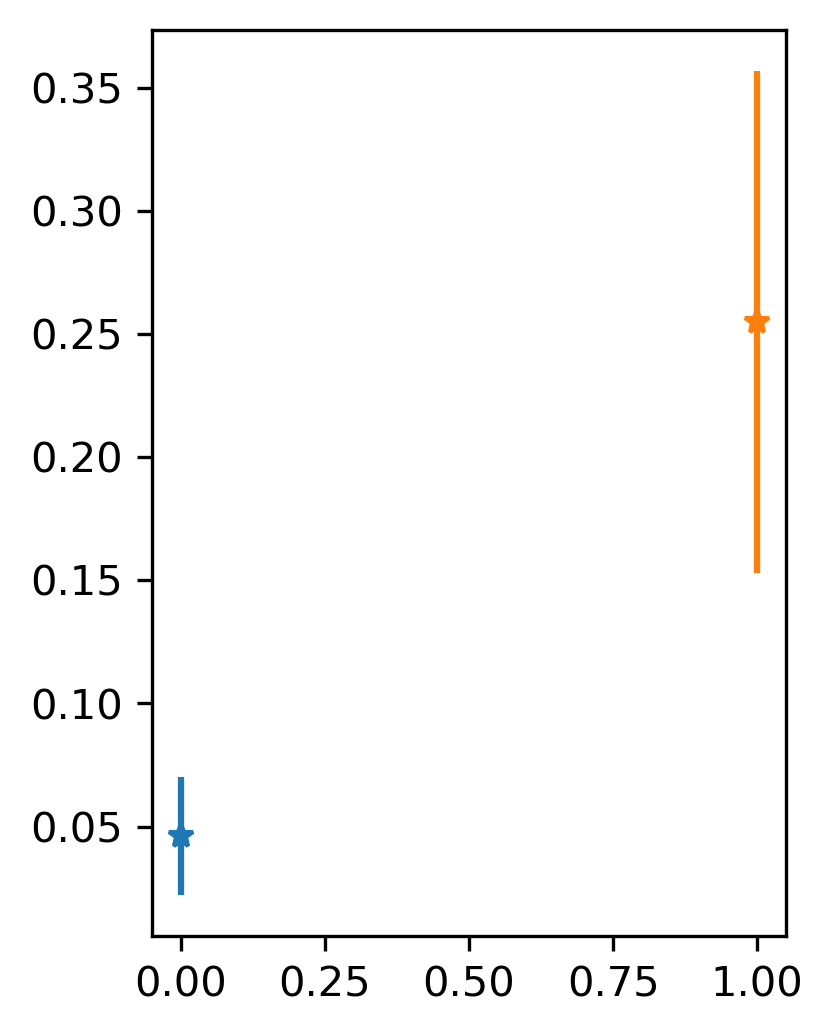

In [18]:
fig = plt.figure('stats', dpi = 300)
ax = fig.add_subplot(121)
target = np.empty(avail.shape)
for i in range(nType):
    pick = avail[i,:] != 0
    assert((connected[i,np.logical_not(pick)] == 0).all())
    target[i,pick] = connected[i,pick]/avail[i,pick]
    mt = np.average(target[i,pick])
    st = np.std(target[i,pick])
    print(i, mt, st)
    ax.errorbar(i, mt, st, marker='*')
    #target = strength/connected
    #ax.errorbar(i+0.5, np.average(target), np.std(target))

In [179]:
mindis = np.float('inf')
meandis = 0
for i in range(1,nblock):
    p2 = np.power(blkPos - np.roll(blkPos,i,1),2)
    dis = np.sqrt(np.sum(p2,0))
    mind = np.min(dis)
    meandis = meandis + np.sum(dis)
    if mindis > mind:
        mindis = mind
print(meandis/2/(nblock*(nblock-1)))
print(mindis)

3.994896673387097
2.146566


In [164]:
a = np.arange(0,10).reshape(2,5)

In [174]:
np.roll(a,1,1)

array([[4, 0, 1, 2, 3],
       [9, 5, 6, 7, 8]])

(0, 1)

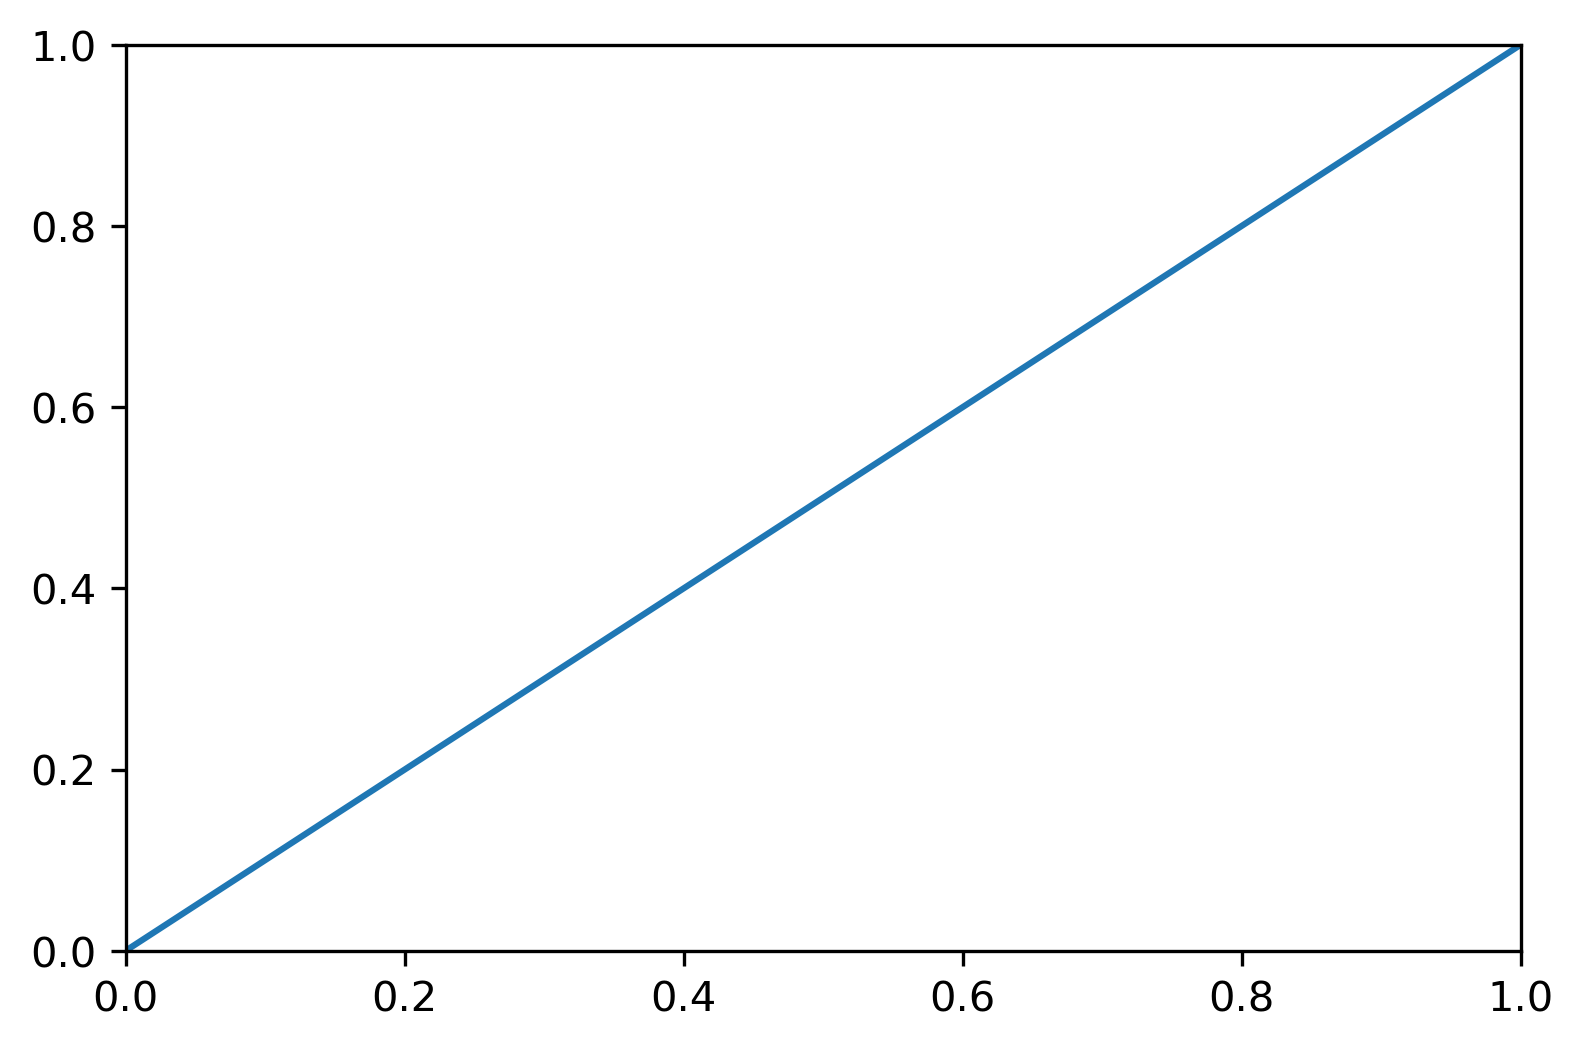